In [54]:
import scipy

test = scipy.io.loadmat("../../predicted_array.mat")

(100, 51, 512)

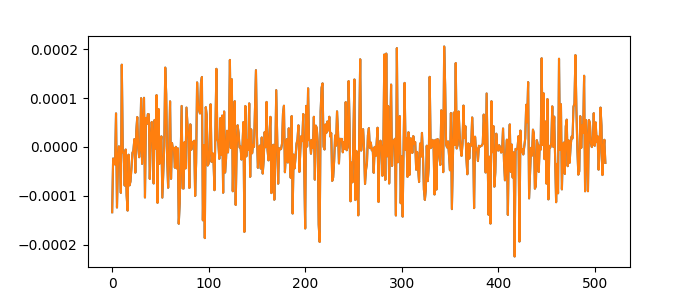

In [58]:
import matplotlib.pyplot as plt

%matplotlib widget

fig, ax = plt.subplots()
ax.plot(test["predicted_array"][0, 0, :])
ax.plot(test["predicted_array"][0, 0, :])

In [1]:
import sys
import torch

sys.path.insert(0, "..")
basedir = "../.."

from common.config import create_object, load_config

%matplotlib widget

torch._dynamo.config.suppress_errors = True
torch._dynamo.disable()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

dconfig = load_config("../autoencoder/configs/data/burgersscale.yaml")
dconfig.datasize.spacedim = 1
dconfig.datasize.time = 51
dset = create_object(dconfig)

In [2]:
import models

wconfig = load_config("../autoencoder/configs/experiments/weldconv_periodic.yaml")
experiment = create_object(wconfig)

weld = experiment.create_weld(dset, k=3, windows=1, passparams=False)

weld.train_aes(300, lr=1e-3)
out = weld.train_propagators(300, lr=1e-4)

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Training 1 WeldNet AEs
Number of NN trainable parameters 200004
Starting training WeldNet AE 1/1 (0->66) at Sun Jun 22 01:38:39 2025...
train torch.Size([400, 67, 512]) test (100, 67, 512)
1: Train Loss 1.274e-01, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.721746, 0.770397, 0.987302
11: Train Loss 4.304e-03, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.091415, 0.132451, 0.642303


KeyboardInterrupt: 

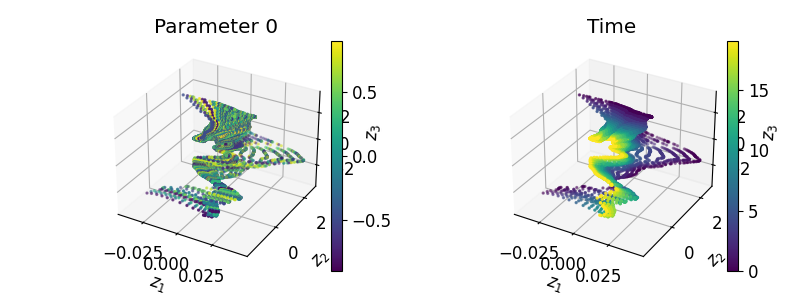

In [5]:
weld.aes[0].reduced = 3
models.WeldHelper.plot_encoding_window(weld, threedim=True)

In [6]:
import models

wconfig = load_config("../autoencoder/configs/experiments/weldnormal.yaml")
experimentn = create_object(wconfig)

weldn = experimentn.create_weld(dset, k=3, windows=1, passparams=False)
weldn.train_aes(300, lr=1e-3)
out = weldn.train_propagators(300, lr=1e-4)

Training 1 WeldNet AEs
Number of NN trainable parameters 1518515
Starting training WeldNet AE 1/1 (0->66) at Fri Jun 20 15:50:14 2025...
train torch.Size([400, 67, 512]) test (100, 67, 512)
1: Train Loss 9.444e-02, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.627106, 0.674722, 1.049334
11: Train Loss 4.968e-03, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.113908, 0.159819, 0.506958
21: Train Loss 1.640e-03, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.057704, 0.089243, 0.368740
31: Train Loss 8.157e-04, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.043307, 0.065575, 0.296696
41: Train Loss 6.381e-04, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.042603, 0.061456, 0.279555
51: Train Loss 4.251e-04, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.032451, 0.046580, 0.225030
61: Train Loss 7.372e-04, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.040945, 0.052630, 0.230376
71: Train Loss 3.322e-04, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.024192, 0.035567, 0.180856
81: Train L

KeyboardInterrupt: 

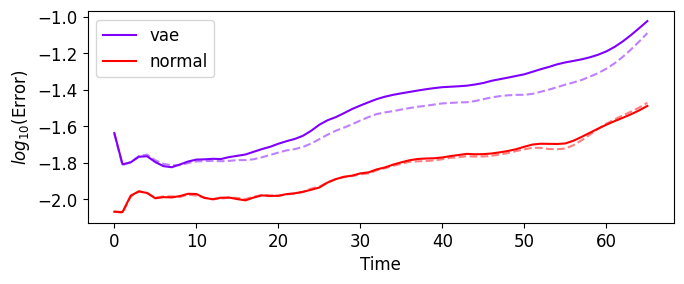

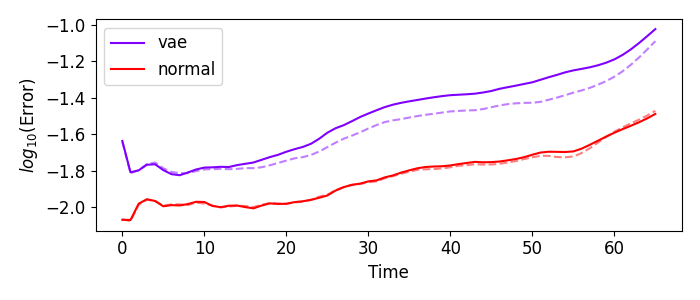

In [16]:
models.WeldHelper.compare_projops([weld, weldn], ["vae", "normal"])

In [ ]:
  import models
  import matplotlib
  import utils
  import numpy as np
  import matplotlib.pyplot as plt

  def plot_encoding_window(weld, ws=-1, p=-1, writer=None, step=None, tensorboard=False, maxscatter=10000, testonly=False, threedim=False):
      if p == -1:
        p = utils.determine_params(weld.dataset.params)

      if type(p) == type(0):
        p = [p]

      if ws == -1:
        ws = range(len(weld.aes))
      
      if type(ws) == type(0):
        ws = [ws]

      for w in ws:
        dim = weld.aes[w].reduced

        arr = weld.tests[w] if testonly else np.concat([weld.tests[w], weld.trains[w].cpu().numpy()]) 
        params = weld.paramtest if testonly else np.concat([weld.paramtest, weld.paramtrain]) 

        arr = torch.tensor(arr).to(weld.device, dtype=torch.float32)
        test = arr[:, :, -1:]

        enc = weld.encode_window(w, arr)
        testout = enc[:, :, -1:]

        points = enc.cpu().detach().numpy()
      
        T = arr.shape[1] 
        params = np.repeat(params[:, None, :], T, axis=1)
        time_idx = np.arange(T)[None, :, None]
        time_arr = np.repeat(time_idx, points.shape[0], axis=0)

        points = np.concat([points, params, time_arr], axis=-1)
        points = points.reshape([-1, points.shape[-1]])

        plt.rcParams.update({'font.size': 12})
        for pp in p:
          fig = plt.figure(figsize=(8, 3))

          if dim == 2 or tensorboard or not threedim:
            ax0 = fig.add_subplot(121)
            ax1 = fig.add_subplot(122)

            sc0 = ax0.scatter(points[:maxscatter, 0], points[:maxscatter, 1], c=points[:maxscatter, -2], s=2)
            plt.colorbar(sc0, ax=ax0, location="right", pad=0)
            ax0.set_xlabel("$z_1$")
            ax0.set_ylabel("$z_2$")
            ax0.set_title(f"Parameter {pp}")
            
            sc1 = ax1.scatter(points[:maxscatter, 0], points[:maxscatter, 1], c=points[:maxscatter, -1], s=2)
            plt.colorbar(sc1, ax=ax1, location="right", pad=0)
            ax1.set_xlabel("$z_1$")
            ax1.set_ylabel("$z_2$")
            ax1.set_title(f"Time")
          elif dim >= 3:
            ax0 = fig.add_subplot(121, projection="3d")
            ax1 = fig.add_subplot(122, projection="3d")

            sc0 = ax0.scatter(points[:maxscatter, 0], points[:maxscatter, 1], points[:maxscatter, 2], c=points[:maxscatter, -2], s=2)
            plt.colorbar(sc0, ax=ax0, location="right", pad=0)
            ax0.set_xlabel("$z_1$")
            ax0.set_ylabel("$z_2$")
            ax0.set_zlabel("$z_3$")
            ax0.set_title(f"Parameter {pp}")

            sc1 = ax1.scatter(points[:maxscatter, 0], points[:maxscatter, 1], points[:maxscatter, 2], c=points[:maxscatter, -1], s=2)
            plt.colorbar(sc1, ax=ax1, location="right", pad=0)
            ax1.set_xlabel("$z_1$")
            ax1.set_ylabel("$z_2$")
            ax1.set_zlabel("$z_3$")
            ax1.set_title(f"Time")
          else:
            assert(False)

          fig.tight_layout()

          if tensorboard:
            assert(step is not None)
            fig.suptitle(step)
            writer.add_figure(f'main/latent-p{pp}', fig, global_step=step)
            writer.flush()
            torch.cuda.empty_cache()
            plt.close(fig)

        return test, testout

In [ ]:
models.WeldHelper.plot_ae_projection(weld)

RuntimeError: linear(): input and weight.T shapes cannot be multiplied (500x511 and 512x500)

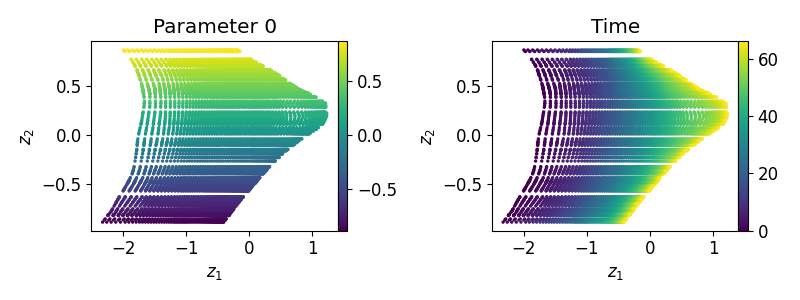

In [ ]:
test, testout = plot_encoding_window(weld)

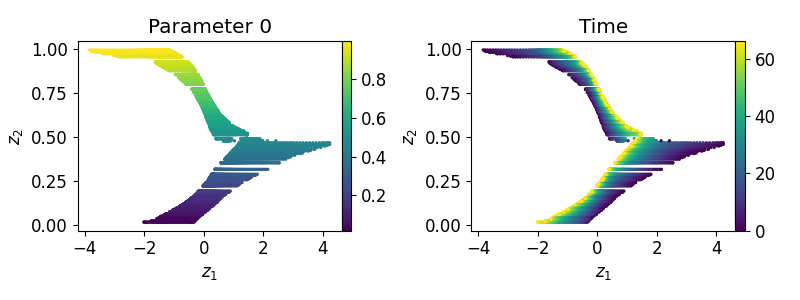

In [ ]:
test, testout = plot_encoding_window(weldnormal)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm

# Configuration
batch_size = 128
epochs = 10
learning_rate = 3e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data transforms: resize 28x28 MNIST to 224x224 for ViT input
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Datasets and loaders
target_transform = None
train_dataset = datasets.MNIST(root='data', train=True, download=True,
                               transform=data_transform, target_transform=target_transform)
test_dataset = datasets.MNIST(root='data', train=False, download=True,
                              transform=data_transform, target_transform=target_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Initialize Vision Transformer
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=10)

# replace patch embed proj to take 1 channel
old_proj = model.patch_embed.proj
model.patch_embed.proj = nn.Conv2d(
    in_channels=1,
    out_channels=old_proj.out_channels,
    kernel_size=old_proj.kernel_size,
    stride=old_proj.stride,
    padding=old_proj.padding,
    bias=old_proj.bias is not None
)

model = model.to(device)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in loader:
        print(str(labels))
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Evaluation loop
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Main training script
best_acc = 0.0
for epoch in range(1, epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)

    print(f"Epoch [{epoch}/{epochs}]:"
          f" Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}"
          f" | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_vit_mnist.pth')

print(f"Training complete. Best Validation Accuracy: {best_acc:.4f}")


tensor([7, 3, 0, 6, 6, 6, 1, 7, 5, 7, 1, 6, 3, 1, 6, 8, 6, 6, 3, 3, 1, 1, 2, 0,
        4, 5, 2, 6, 7, 0, 9, 7, 2, 5, 4, 2, 2, 3, 1, 0, 3, 0, 0, 3, 7, 6, 0, 1,
        2, 8, 8, 1, 1, 2, 2, 6, 8, 7, 7, 9, 6, 7, 8, 9, 7, 4, 6, 7, 0, 7, 0, 9,
        7, 3, 0, 2, 4, 2, 6, 8, 6, 2, 4, 6, 0, 2, 5, 5, 0, 3, 6, 5, 0, 8, 4, 4,
        7, 0, 6, 6, 0, 9, 2, 7, 5, 9, 4, 9, 0, 7, 3, 0, 6, 8, 0, 8, 0, 0, 6, 2,
        3, 9, 4, 0, 7, 0, 0, 4])
tensor([9, 5, 8, 7, 3, 6, 1, 1, 3, 2, 7, 1, 4, 4, 8, 5, 8, 5, 2, 7, 2, 0, 8, 2,
        0, 6, 1, 1, 2, 7, 3, 3, 0, 1, 3, 3, 3, 3, 3, 2, 8, 8, 9, 6, 7, 5, 9, 1,
        3, 0, 5, 7, 6, 8, 3, 6, 3, 6, 8, 7, 7, 3, 6, 4, 0, 1, 7, 3, 1, 1, 4, 0,
        7, 4, 0, 6, 4, 1, 3, 8, 7, 6, 1, 0, 6, 1, 1, 1, 6, 7, 2, 2, 1, 1, 1, 6,
        8, 7, 1, 7, 3, 0, 6, 9, 6, 3, 2, 4, 9, 0, 9, 9, 5, 8, 0, 8, 1, 4, 1, 7,
        2, 7, 4, 8, 6, 3, 8, 5])
tensor([6, 9, 1, 3, 4, 8, 9, 0, 3, 0, 3, 7, 4, 2, 2, 0, 8, 0, 3, 8, 8, 1, 2, 0,
        3, 0, 6, 5, 3, 3, 9, 4, 1, 0, 2, 1, 1, 4, 4, 8

KeyboardInterrupt: 

In [ ]:
# import sys
# import torch

# sys.path.insert(0, "..")
# basedir = "../.."

# from common.config import create_object, load_config

# %matplotlib widget

# torch._dynamo.config.suppress_errors = True
# torch._dynamo.disable()
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# import sys
# import copy
# import torch
# import models

# import torch.nn as nn

# # # Ensure your project root is on PYTHONPATH so that common.config can be found
# # sys.path.insert(0, "..")
# # basedir = "../.."

# # from common.config import create_object, load_config

# # def get_data_info(datastr):
# #     data_yaml = f"../autoencoder/configs/data/{datastr}"

# #     dconfig = load_config(data_yaml)
# #     if hasattr(dconfig, "datasize") and hasattr(dconfig.datasize, "spacedim"):
# #         dconfig.datasize.spacedim = 1
# #     dset = create_object(dconfig)

# #     print(datastr, dset.data.shape)
# #     print(dset.params.shape)

# # dsets = ["burgersscale", "burgersshift", "hatsscale", "hatsshift", "kdvscale", "kdvshift"]

# # for dname in dsets:
# #     get_data_info(f"{dname}.yaml")


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [ ]:
import sys
import torch

sys.path.insert(0, "..")
basedir = "../.."

from common.config import create_object, load_config

%matplotlib widget

torch._dynamo.config.suppress_errors = True
torch._dynamo.disable()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

dconfig = load_config("../autoencoder/configs/data/droplettrigpoly2.yaml")
dconfig.datasize.spacedim = 1
dset = create_object(dconfig)

# wconfig = load_config("../autoencoder/configs/experiments/weldnormal.yaml")
# experiment = create_object(wconfig)

# wconfig = load_config("../autoencoder/configs/experiments/donnormal.yaml")
# experiment = create_object(wconfig)

# wpcaconfig = load_config("../autoencoder/configs/experiments/weldpca.yaml")
# wpcaconfig.windows = 3
# wpcaconfig.aeparams.reduced = 10
# pcaexperiment = create_object(wpcaconfig)

interactive(children=(IntSlider(value=0, description='t0'), IntSlider(value=0, description='t1'), FloatSlider(…

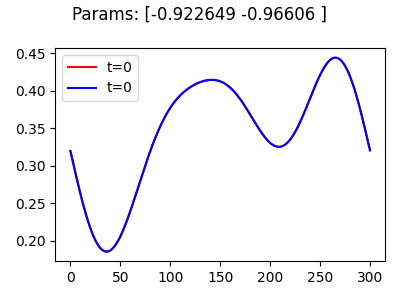

In [ ]:
dset.plot_data(mode="params")

In [ ]:
import sys
import copy
import torch
import models

import torch.nn as nn

sys.path.insert(0, "..")
basedir = "../.."

from common.config import create_object, load_config

def train_weld_from_yaml(datastr, expstr, k, **args):
    W = args.get("W", 1)
    krrtrans = args.get("krrtrans", False)
    epochs = args.get("epochs", 300)
    lamb = args.get("lamb", 0)
    finetune = args.get("finetune", True)
    accumulateprop = args.get("accumulateprop", False)

    data_yaml = f"../autoencoder/configs/data/{datastr}"
    exp_yaml  = f"../autoencoder/configs/experiments/{expstr}"

    dconfig = load_config(data_yaml)
    if hasattr(dconfig, "datasize") and hasattr(dconfig.datasize, "spacedim"):
        dconfig.datasize.spacedim = 1
    dset = create_object(dconfig)

    wconfig = load_config(exp_yaml)
    experiment = create_object(wconfig)

    if isinstance(experiment, models.WeldHelper):
        weld1 = experiment.create_weld(dset, windows=W, k=k, td=None, seed=0, device=device, accumulateprop=accumulateprop)

        if wconfig["aeclass"] == "GIAutoencoder":
            weld1.train_aes(epochs, lr=1e-3, save=False, gridbatch=32)
            weld1.train_propagators(epochs, lr=1e-4, save=False)
        else:
            if lamb > 0:
                weld1.train_aes_plus_props(epochs, lr=1e-3, save=False, lamb=lamb)

                if finetune:
                    weld1.train_propagators(epochs, lr=1e-4 * lamb, save=False)

            elif lamb == -1:
                weld1.train_aes_alternate_props(epochs, lr=1e-3, save=False)

                if finetune:
                    weld1.train_propagators(epochs, lr=1e-4, save=False)

            else:
                weld1.train_aes(epochs, lr=1e-3, save=False)
                weld1.train_propagators(2*epochs, lr=5e-4, save=False)

        if W > 1:
            if krrtrans:
                weld1.train_transcoders_krr(save=False, ridge=1e-4, kernel="rbf")
            else:
                weld1.train_transcoders(epochs, lr=1e-4, save=False)

    else:
        weld1 = experiment.create_timeinput(dset, td=None, seed=0, device=device)
        weld1.train_model(epochs * 2)

    return weld1

dargs = {"W": 1, "epochs": 500}

weldnormalFT = train_weld_from_yaml("droplettrigpoly2.yaml", "weldnormal.yaml", 6, lamb=0.5, **dargs)
weldtcFT = train_weld_from_yaml("droplettrigpoly2.yaml", "weldtc.yaml", 6, lamb=0.5, **dargs)

Training 1 WeldNet AEs
Number of NN trainable parameters 1310307
Starting training WeldNet AE + Prop 1/1 (0->100) at Mon Jun 16 12:42:28 2025...
train torch.Size([200, 101, 301]) test (50, 101, 301)
1: Train Loss 1.599e-02 + 2.788e-04, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.220707, 0.271299, 0.631858
11: Train Loss 4.355e-03 + 8.473e-08, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.125675, 0.157297, 0.365799
21: Train Loss 1.833e-03 + 1.398e-06, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.085905, 0.110915, 0.319141
31: Train Loss 1.023e-03 + 1.639e-06, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.073947, 0.095422, 0.249446
41: Train Loss 8.531e-04 + 1.130e-06, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.074543, 0.095816, 0.253251
51: Train Loss 9.667e-04 + 4.885e-06, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.069443, 0.088914, 0.240735
61: Train Loss 3.290e-04 + 1.406e-06, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.044507, 0.058822, 0.193748
71: Train Loss 2.8

In [ ]:
ff = train_weld_from_yaml("droplettrigpoly2.yaml", "ffnetnormal.yaml", 6, lamb=0, **dargs)

Number of NN trainable parameters 1404501
Starting training TI model FFNet at Mon Jun 16 12:50:48 2025...
train torch.Size([200, 101, 301]) test (50, 101, 301)
1: Train Loss 7.953e-02, LR 1.000e-04, Relative TI Error (1, 2, inf): 0.697388, 0.767594, 1.365184
11: Train Loss 4.237e-03, LR 1.000e-04, Relative TI Error (1, 2, inf): 0.126720, 0.157809, 0.374558
21: Train Loss 3.972e-03, LR 1.000e-04, Relative TI Error (1, 2, inf): 0.122029, 0.152314, 0.352581
31: Train Loss 3.207e-03, LR 1.000e-04, Relative TI Error (1, 2, inf): 0.108509, 0.137729, 0.341370
41: Train Loss 1.591e-03, LR 1.000e-04, Relative TI Error (1, 2, inf): 0.086526, 0.112319, 0.326568
51: Train Loss 1.267e-03, LR 1.000e-04, Relative TI Error (1, 2, inf): 0.066487, 0.089586, 0.293425
61: Train Loss 9.270e-04, LR 1.000e-04, Relative TI Error (1, 2, inf): 0.044365, 0.065278, 0.268463
71: Train Loss 7.500e-04, LR 1.000e-04, Relative TI Error (1, 2, inf): 0.033864, 0.053056, 0.242699
81: Train Loss 6.579e-04, LR 1.000e-04, R

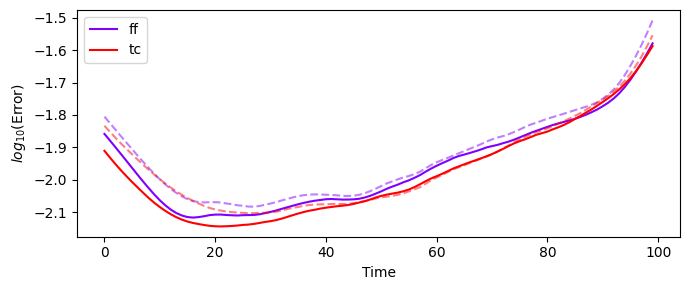

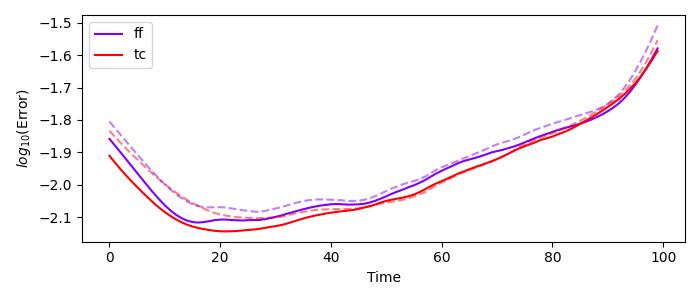

In [ ]:
models.WeldHelper.compare_projops([weldnormalFT, weldtcFT], ["ff", "tc"])

tensor([[0.4508, 0.4425, 0.4317,  ..., 0.4809, 0.4730, 0.4639],
        [0.4553, 0.4442, 0.4301,  ..., 0.4780, 0.4723, 0.4643],
        [0.4514, 0.4402, 0.4303,  ..., 0.4789, 0.4678, 0.4601],
        ...,
        [0.4532, 0.4410, 0.4353,  ..., 0.4820, 0.4717, 0.4616],
        [0.4533, 0.4432, 0.4337,  ..., 0.4800, 0.4685, 0.4596],
        [0.4513, 0.4419, 0.4313,  ..., 0.4810, 0.4681, 0.4588]],
       device='mps:0')

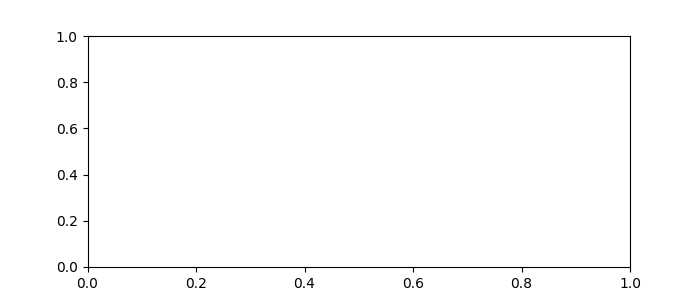

In [ ]:
import matplotlib.pyplot as plt
vae = weldvae.aes[0]
n_samples = 100
z = torch.randn(n_samples, 3, device=device)

# 4. Decode to get your synthetic datapoints
with torch.no_grad():
    samples = vae.decode(z)   # shape: (n_samples, datadim) or (n, H, W) if datadim=2

fig, ax = plt.subplots()
samples

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import pickle


class FFVAE(nn.Module):
  def __init__(self, encodeSeq, decodeSeq, activation=nn.ReLU(), datadim=1):
    super().__init__()
    self.activation = activation
    self.datadim = datadim
    self.input_dim = None

    self.encoder_net = FFNet(seq=encodeSeq[:-1], activation=activation)
    hidden_size = encodeSeq[-2] if len(encodeSeq) > 1 else encodeSeq[0]
    self.latent_dim = encodeSeq[-1]

    self.fc_mu = nn.Linear(hidden_size, self.latent_dim)
    self.fc_logvar = nn.Linear(hidden_size, self.latent_dim)

    self.decoder_net = FFNet(seq=decodeSeq[1:], activation=activation)
    self.fc_output = nn.Linear(decodeSeq[-1], None)

  def _init_output_layer(self, feature_dim):
    if self.fc_output.out_features is None:
      self.fc_output = nn.Linear(self.decoder_net.seq[-1], feature_dim)
      self.input_dim = feature_dim

  def encode(self, x, variance=False):
    if self.datadim == 2:
      batch = x.size(0)
      x = x.view(batch, -1)

    if self.input_dim is None:
      self._init_output_layer(x.size(1))

    h = self.encoder_net(x)
    mu = self.fc_mu(h)
    logvar = self.fc_logvar(h)

    if variance:
        return mu, logvar
    else:
        return mu

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

  def decode(self, z):
    h = self.decoder_net(z)
    recon_flat = self.fc_output(h)

    if self.datadim == 2:
      side = int(np.sqrt(self.input_dim))
      recon = recon_flat.view(-1, side, side)
      return recon

    return recon_flat

  def forward(self, x, variance=False):
    mu, logvar = self.encode(x, variance=True)
    z = self.reparameterize(mu, logvar)
    recon = self.decode(z)

    if variance:
        return recon, mu, logvar
    else:
        return recon

  def loss_function(self, recon, x, mu, logvar, reduction='mean'):
    if self.datadim == 2:
      batch = x.size(0)
      x_flat = x.view(batch, -1)
    else:
      x_flat = x

    recon_flat = recon.view_as(x_flat)
    recon_loss = F.mse_loss(recon_flat, x_flat, reduction=reduction)

    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    if reduction == 'mean':
      kld = kld / x.size(0)

    return recon_loss + kld

  def save_model(self, filename):
    addr = os.path.join(BASEDIR, filename)
    os.makedirs(os.path.dirname(addr), exist_ok=True)

    with open(addr, "wb") as handle:
      pickle.dump({"model": self}, handle, protocol=pickle.HIGHEST_PROTOCOL)



/Users/bdahal6/Desktop/aenet/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/20 - Avg Loss: 0.0843
Epoch 2/20 - Avg Loss: 0.0531
Epoch 3/20 - Avg Loss: 0.0527
Epoch 4/20 - Avg Loss: 0.0505
Epoch 5/20 - Avg Loss: 0.0495
Epoch 6/20 - Avg Loss: 0.0484
Epoch 7/20 - Avg Loss: 0.0481
Epoch 8/20 - Avg Loss: 0.0480
Epoch 9/20 - Avg Loss: 0.0466
Epoch 10/20 - Avg Loss: 0.0463
Epoch 11/20 - Avg Loss: 0.0462
Epoch 12/20 - Avg Loss: 0.0452
Epoch 13/20 - Avg Loss: 0.0451
Epoch 14/20 - Avg Loss: 0.0446
Epoch 15/20 - Avg Loss: 0.0442
Epoch 16/20 - Avg Loss: 0.0440
Epoch 17/20 - Avg Loss: 0.0442
Epoch 18/20 - Avg Loss: 0.0436
Epoch 19/20 - Avg Loss: 0.0436
Epoch 20/20 - Avg Loss: 0.0435
Test Avg Recon Loss: 33.6692
Test Avg MMD Loss:   0.0061


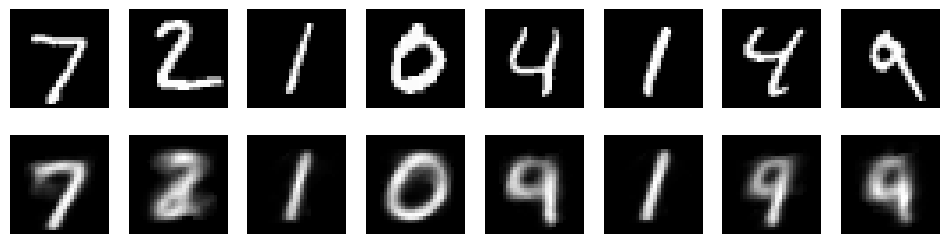

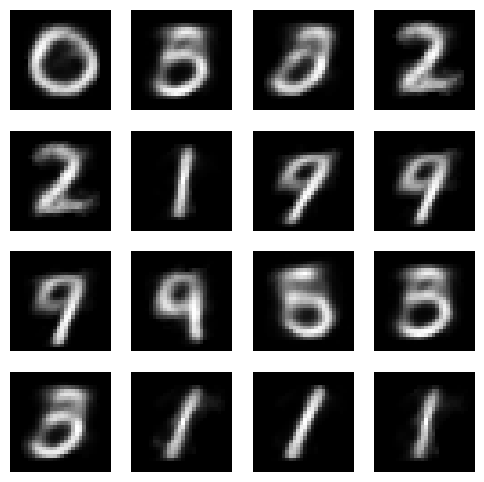

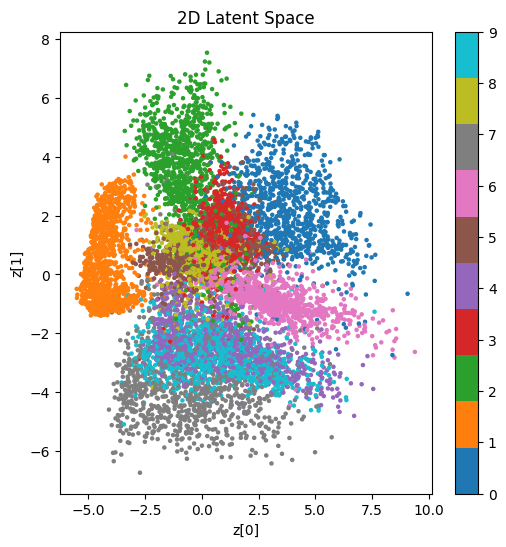

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import math

# -----------------------------
# 1) Encoder and Decoder
# -----------------------------
class Encoder(nn.Module):
    def __init__(self, input_dim, z_dim):
        super(Encoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 400),
            nn.ReLU(),
            nn.Linear(400, z_dim)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)

class Decoder(nn.Module):
    def __init__(self, z_dim, output_dim):
        super(Decoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 400),
            nn.ReLU(),
            nn.Linear(400, output_dim)
        )

    def forward(self, z):
        x = torch.sigmoid(self.net(z))
        return x.view(-1, 1, 28, 28)

# -----------------------------
# 2) Sample prior: Label-conditional mixture of Gaussians
# -----------------------------
def sample_prior_with_labels(labels, z_dim, num_classes=10, radius=3.0):
    # labels: tensor of shape [batch_size] with values in [0, num_classes)
    batch_size = labels.size(0)
    # compute component means on a circle (first two dims)
    angles = torch.linspace(0, 2 * math.pi * 0.95, steps=num_classes, device=labels.device)
    means = torch.zeros(num_classes, z_dim, device=labels.device)
    means[:, 0] = radius * torch.cos(angles)
    if z_dim > 1:
        means[:, 1] = radius * torch.sin(angles)
    # sample prior per example
    # gaussian noise added to each component mean
    z_prior = torch.randn(batch_size, z_dim, device=labels.device)
    z_prior = z_prior + means[labels]
    return z_prior

# -----------------------------
# 3) MMD computation
# -----------------------------
def compute_mmd(z, z_prior, sigma=None):
    def pdist_sq(a, b):
        a2 = (a**2).sum(dim=1, keepdim=True)
        b2 = (b**2).sum(dim=1, keepdim=True)
        return a2 - 2 * a @ b.t() + b2.t()

    if sigma is None:
        with torch.no_grad():
            dists = pdist_sq(z, z)
            sigma = torch.sqrt(dists.median())

    K_xx = torch.exp(-pdist_sq(z, z) / (2 * sigma**2))
    K_yy = torch.exp(-pdist_sq(z_prior, z_prior) / (2 * sigma**2))
    K_xy = torch.exp(-pdist_sq(z, z_prior) / (2 * sigma**2))

    n, m = z.size(0), z_prior.size(0)
    mmd = (K_xx.sum() - torch.diagonal(K_xx).sum()) / (n*(n-1)) \
          + (K_yy.sum() - torch.diagonal(K_yy).sum()) / (m*(m-1)) \
          - 2 * K_xy.mean()
    return mmd

# -----------------------------
# 4) Data loader
# -----------------------------
def get_mnist_dataloader(batch_size=128, train=True, shuffle=True, num_workers=4):
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    dataset = datasets.MNIST(root='./data', train=train, download=True, transform=transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle,
                        num_workers=num_workers, pin_memory=True, drop_last=True)
    return loader

# -----------------------------
# 5) Training and evaluation
# -----------------------------
def train_mmd_ae(encoder, decoder, train_loader, device, lr=1e-3, epochs=10, λ=1.0, z_dim=2):
    encoder.to(device)
    decoder.to(device)
    optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr)

    for epoch in range(1, epochs+1):
        encoder.train()
        decoder.train()
        total_loss = 0.0

        for x, labels in train_loader:
            x = x.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            z = encoder(x)
            x_hat = decoder(z)

            # reconstruction
            recon_loss = F.mse_loss(x_hat, x, reduction='mean')
            # sample label-conditional prior
            z_prior = sample_prior_with_labels(labels, z_dim, num_classes=10)
            mmd_loss = compute_mmd(z, z_prior)
            loss = recon_loss + λ * mmd_loss

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch}/{epochs} - Avg Loss: {avg_loss:.4f}")


def evaluate_mmd_ae(encoder, decoder, test_loader, device, z_dim=2):
    encoder.eval()
    decoder.eval()
    total_recon, total_mmd = 0.0, 0.0
    n_batches = 0

    with torch.no_grad():
        for x, labels in test_loader:
            x = x.to(device)
            labels = labels.to(device)
            z = encoder(x)
            x_hat = decoder(z)

            total_recon += F.mse_loss(x_hat, x, reduction='sum').item()
            z_prior = sample_prior_with_labels(labels, z_dim, num_classes=10)
            total_mmd += compute_mmd(z, z_prior).item()
            n_batches += 1

    batch_size = test_loader.batch_size
    avg_recon = total_recon / (n_batches * batch_size)
    avg_mmd = total_mmd / n_batches
    print(f"Test Avg Recon Loss: {avg_recon:.4f}")
    print(f"Test Avg MMD Loss:   {avg_mmd:.4f}")
    return avg_recon, avg_mmd

# -----------------------------
# 6) Visualization (reconstruction, sampling, latent)
# -----------------------------
def show_samples(decoder, device, z_dim, n=16):
    decoder.eval()
    # Here we sample each label equally
    labels = torch.arange(n) % 10
    with torch.no_grad():
        z = sample_prior_with_labels(labels, z_dim)
        x_gen = decoder(z).cpu()

    cols = 4
    rows = n // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*1.5, rows*1.5))
    for idx in range(n):
        r, c = divmod(idx, cols)
        axes[r, c].imshow(x_gen[idx].squeeze(), cmap='gray')
        axes[r, c].axis('off')
    plt.show()

# -----------------------------
# 7) Main execution
# -----------------------------
if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    input_dim = 28 * 28
    z_dim = 2  # for latent plotting and 2D mixing
    batch_size = 256
    train_loader = get_mnist_dataloader(batch_size=batch_size, train=True)
    test_loader  = get_mnist_dataloader(batch_size=batch_size, train=False, shuffle=False)

    encoder = Encoder(input_dim, z_dim)
    decoder = Decoder(z_dim, input_dim)

    # Train
    train_mmd_ae(encoder, decoder, train_loader, device, epochs=20, λ=1.0, z_dim=z_dim)

    # Evaluate
    evaluate_mmd_ae(encoder, decoder, test_loader, device, z_dim=z_dim)

    # Visualize
    show_reconstructions(encoder, decoder, test_loader, device)
    show_samples(decoder, device, z_dim)
    if z_dim == 2:
        plot_latent_space(encoder, test_loader, device)


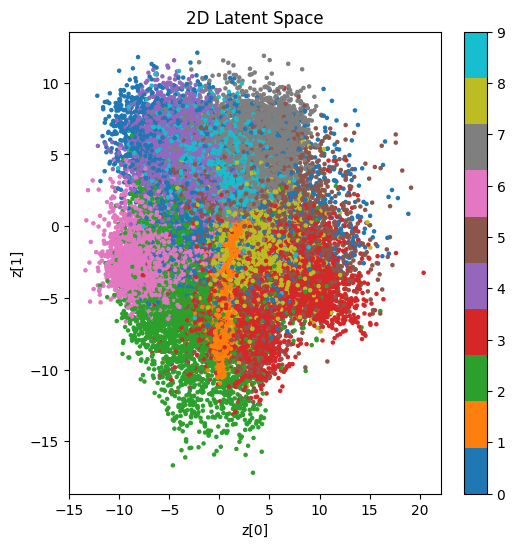

In [ ]:
def plot_latent_space(encoder, dataloader, device):
    encoder.eval()
    zs, labels = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            z = encoder(x)
            zs.append(z.cpu())
            labels.append(y)
    zs = torch.cat(zs)
    labels = torch.cat(labels)

    plt.figure(figsize=(6,6))
    plt.scatter(zs[:,0], zs[:,1], c=labels, cmap='tab10', s=5)
    plt.colorbar()
    plt.xlabel('z[0]')
    plt.ylabel('z[1]')
    plt.title('2D Latent Space')
    plt.show()

plot_latent_space(encoder, train_loader, device)

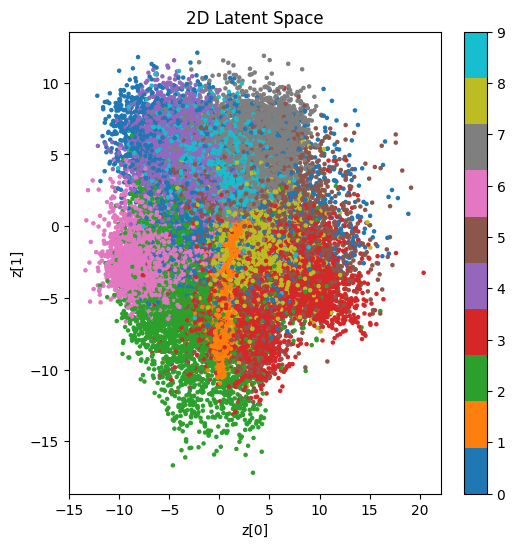

In [ ]:
def plot_latent_space(encoder, dataloader, device):
    encoder.eval()
    zs, labels = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            z = encoder(x)
            zs.append(z.cpu())
            labels.append(y)
    zs = torch.cat(zs)
    labels = torch.cat(labels)

    plt.figure(figsize=(6,6))
    plt.scatter(zs[:,0], zs[:,1], c=labels, cmap='tab10', s=5)
    plt.colorbar()
    plt.xlabel('z[0]')
    plt.ylabel('z[1]')
    plt.title('2D Latent Space')
    plt.show()

plot_latent_space(encoder, train_loader, device)

In [ ]:
import sys
import torch

sys.path.insert(0, "..")
basedir = "../.."

from common.config import create_object, load_config

%matplotlib widget

torch._dynamo.config.suppress_errors = True
torch._dynamo.disable()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

import skdim.id
import numpy as np

dsets = []
for dname in ["droplettrigpoly1", "droplettrigpoly2"]:
  print(dname)
  dconfig = load_config(f"../autoencoder/configs/data/{dname}.yaml")
  dconfig.datasize.spacedim = 1
  dset = create_object(dconfig)

  n = dset.data.shape[0]
  T = dset.data.shape[1]
  data0 = dset.data[:, 0].reshape([n, -1])
  dataF = dset.data[:, -1].reshape([n, -1])

  alldata = dset.data.reshape([n*T, -1])
  np.random.shuffle(alldata)
  alldata = alldata[:n]

  estimator = skdim.id.MLE(integral_approximation='guaranteed.convergence')
  print("initial", estimator.fit(data0).dimension_)
  print("final", estimator.fit(dataF).dimension_)
  print("all", estimator.fit(alldata).dimension_)

  print()
  
  dsets.append(dset)

droplettrigpoly1
initial 1.8516107921901233
final 2.2936826104735664
all 4.3349109937022074

droplettrigpoly2
initial 1.9302106279172349
final 2.047024770198656
all 2.494101397125745



interactive(children=(IntSlider(value=0, description='t0', max=50), IntSlider(value=0, description='t1', max=5…

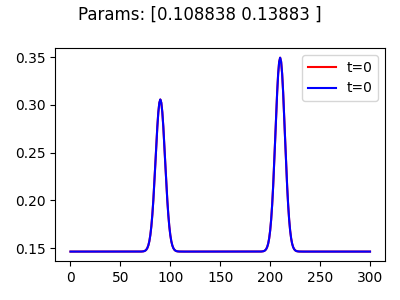

In [ ]:

dsets[0].plot_data(mode="params")